In [ ]:
#%pip install --upgrade setuptools

In [2]:
%pip install python-Levenshtein

#this needs C dependencies, and you have to install VS Build Tools- see here
#https://stackoverflow.com/questions/29846087/error-microsoft-visual-c-14-0-is-required-unable-to-find-vcvarsall-bat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149852 sha256=95c5605d478ea9d6a594365b8a48c40b0e9bbe32c035bd4ca7906af0e8824db4
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [3]:
import pickle
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Bidirectional, Dropout, LSTM, StringLookup
from tensorflow.keras import Model
from tensorflow.keras.backend import ctc_decode, ctc_batch_cost
from tensorflow.keras.layers import Layer

import Levenshtein as lev

In [7]:
with open('./drive/MyDrive/imgtensor_trsh.pkl','rb') as arrbee:
    img_tensor_trsh = pickle.load(arrbee)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with open('./labeltensor_shpad.pkl','rb') as ry:
    lab_tensor_sh = pickle.load(ry)

In [8]:
charlist = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,-+1234567890'

In [ ]:
img_tensor_trsh = tf.transpose(img_tensor_sh,perm=[0,2,1])

In [ ]:
with open('./imgtensor_trsh.pkl','wb') as wabi:
    pickle.dump(img_tensor_trsh,wabi)

In [ ]:
img_tensor_trsh.shape #looking carefully at previous code, to actually get the sequence to refer to horizontal,
#you have to transpose it

TensorShape([1407, 679, 480])

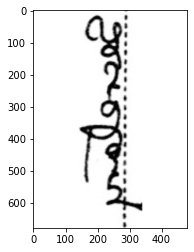

In [ ]:
plt.imshow(img_tensor_trsh[0],cmap='gray')

In [ ]:
lev.distance(['a','b'],['c','d'])

TypeError: distance expected two Strings or two Unicodes

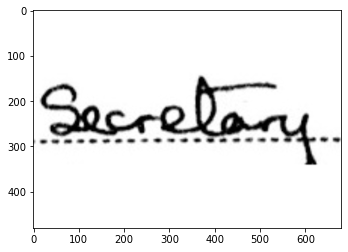

In [ ]:
plt.imshow(tf.transpose(img_tensor_trsh[0],perm=[1,0]),cmap='gray')

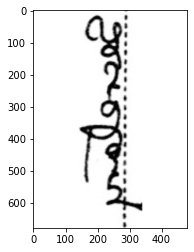

In [ ]:
plt.imshow(tf.transpose(img_tensor_sh[0],perm=[1,0]),cmap='gray')

Consider using the string-lookup method instead

In [9]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [10]:
def decode_preds(pred_model,start,end):
    preds = pred_model.predict(img_tensor_trsh[start:end])
    len_tensor = tf.convert_to_tensor([len([l for l in lab if l>0]) for lab in lab_tensor_sh[start:end]])
    pred_texts = ctc_decode(preds,len_tensor,greedy=True)
    guess_list =  [''.join([charlist[p-1] for p in pred.numpy() if p > -1]) for pred in pred_texts[0][0]]
    prob_list = pred_texts[1].numpy()
    return guess_list,prob_list

In [ ]:
lab_values = [''.join([charlist[l-1] for l in lab if l>0]) for lab in lab_tensor_sh]

In [ ]:
char_to_num = StringLookup(vocabulary=list(charlist))
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True)

In [ ]:
label = char_to_num(tf.strings.unicode_split(lab_values,input_encoding='UTF-8'))

In [ ]:
# class LevEval(tf.keras.callbacks.Callback):
    
#     def __init__(self,imgten,labten):
#         super().__init__()
#         self.imgten = imgten
#         self.labten = labten
    
#     def levDistance(self, epoch, logs = None):

#         #don't like Levenshtein? check out the package, you can use Hamming,Jaro, Jaro-Winkler
#         #say, here's an idea- try using median from a couple of the top greedy algos to get an answer
#         #definitely a 'future' idea
#         #consider tf.edit_distance()

#         #I'd really prefer to do this as a func, but I'm being driven mad by tensor nonsense
#         #lightly adapted from the keras audio example above
        
#         preds = []
#         trues = []
#         for i in range(len(self.imgten)):
#             img = self.imgten[i]
#             lab = self.labten[i]
#             pred_model = Model(model.get_layer(name='image').input, model.get_layer(name='dense2').output)
            
            

In [ ]:
# def levDistance(y_true,y_pred):
#     preds = [''.join([charlist[p-1] for p in pred.numpy() if p>0]) for pred in y_pred]
#     truth = [''.join([charlist[p-1] for p in lab.numpy() if p>0]) for lab in y_true]
#     return  tf.expand_dims(tf.reduce_mean())

In [11]:
def post_distance(pred_model,start,end):
    preds, _ = decode_preds(pred_model,start,end)
    trues = [''.join([charlist[p-1] for p in lab.numpy()]) for lab in lab_tensor_sh[start:end]]
    return sum([lev.distance(trues[i],preds[i]) for i in range(end-start)])/(end-start)
# you can normalize the lev distance by dividing by length of longest word, but we'll leave that for now

In [15]:
input_img = Input(shape=(679,480,1),name='image',dtype="float32")
#labels = Input(shape=(None,),name='label',dtype="int32") #we're using ragged tensors, so no set shape

x = Conv2D(32,(3,3),activation='relu',name='Conv1')(input_img)
x = MaxPooling2D((2,2), name = "pool1")(x)

x = Conv2D(64,(3,3),activation='relu',name='Conv2')(x)
x = MaxPooling2D((2,2), name = "pool2")(x)

shape = ((679//4)-1,((480//4)-2)*64)

x = Reshape(target_shape=shape, name = 'reshape')(x)
x = Dense(64, activation='relu', name ='dense1')(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(128,return_sequences=True, dropout=0.25))(x)
x = Bidirectional(LSTM(64,return_sequences=True,dropout=0.25))(x)


#x = Dense(len(charlist)+2,activation='softmax',name='dense2')(x)
output = Dense(len(charlist)+2,activation='softmax',name='dense2')(x)
#output = CTCLayer(name='ctc_loss')(labels,x)

model = Model(input_img,output,name='basic-OCR')
model.compile(optimizer='adam',loss=CTCLoss)
              #,metrics=[levDistance])


In [16]:
model.summary()

Model: "basic-OCR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 679, 480, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 677, 478, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 338, 239, 32)      0         
                                                                 
 Conv2 (Conv2D)              (None, 336, 237, 64)      18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 168, 118, 64)      0         
                                                                 
 reshape (Reshape)           (None, 168, 7552)         0         
                                                                 
 dense1 (Dense)              (None, 168, 64)           48

In [17]:
eps = 100
history = model.fit(img_tensor_trsh,lab_tensor_sh,validation_split=0.2, epochs=eps)

Epoch 1/100
36/36 [==============================] - 21s 418ms/step - loss: 103.1621 - val_loss: 55.7098
Epoch 2/100
36/36 [==============================] - 12s 336ms/step - loss: 46.1431 - val_loss: 85.1150
Epoch 3/100
36/36 [==============================] - 12s 339ms/step - loss: 39.8400 - val_loss: 102.3771
Epoch 4/100
36/36 [==============================] - 12s 339ms/step - loss: 37.0693 - val_loss: 46.7719
Epoch 5/100
36/36 [==============================] - 12s 340ms/step - loss: 34.7478 - val_loss: 38.6453
Epoch 6/100
36/36 [==============================] - 12s 338ms/step - loss: 33.7777 - val_loss: 52.1968
Epoch 7/100
36/36 [==============================] - 12s 339ms/step - loss: 32.9012 - val_loss: 54.3376
Epoch 8/100
36/36 [==============================] - 12s 341ms/step - loss: 32.2252 - val_loss: 54.7462
Epoch 9/100
36/36 [==============================] - 12s 340ms/step - loss: 31.7338 - val_loss: 35.9090
Epoch 10/100
36/36 [==============================] - 12s 339m

In [18]:
pred_model = Model(model.get_layer(name='image').input, model.get_layer(name='dense2').output)

In [25]:
decode_preds(pred_model,0,10)[0]

['S', 'N', '--', '2', 'M', 'N', '--,', '--', 'P', 'R']

In [28]:
[''.join([charlist[l-1] for l in lab if l>0]) for lab in lab_tensor_sh[0:10]]

['Secretary',
 'Neg',
 '--- Steven A',
 '36',
 'M',
 'Flowers Ruby J',
 '---, Frank H',
 '---, Vera P',
 'Edwards  Ada',
 'Welch Ernestine']

In [ ]:
ctc_decode(pred_model.predict(img_tensor_trsh[25:35]),
           tf.convert_to_tensor([len([l for l in lab if l>0]) for lab in lab_tensor_sh[25:35]]),
          greedy=True)[1]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.74849695],
       [0.8976889 ],
       [0.24275589],
       [0.24286014],
       [1.1607264 ],
       [0.3224394 ],
       [0.62423396],
       [0.32123038],
       [0.3744369 ],
       [0.57684547]], dtype=float32)>